### Starting with loading and splitting the data

#### This version is a bit improved (still worse than original).
- Removed VRDeck from Total Spending
- Left total spending as numeric column

#### Did not complete the analysis with processing of test data

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# load data from data/train.csv into a pandas dataframe
df = pd.read_csv('data/train.csv')

def process_data(df, isTrainSet=True):

    if isTrainSet:
        # remove Transported from df and assign it to y
        y = df.pop('Transported')
    else:
        y = None


    #copy X
    X = df.copy(deep=True)
    # split Cabin into Deck, Number and Side
    X[['Cabin_Deck', 'Cabin_Number', 'Cabin_Side']] = X['Cabin'].str.split('/', expand=True)
    # cast Cabin_number as int
    X['Cabin_Number'] = X['Cabin_Number'].astype('float64')
    # drop Cabin, PassengerId and Name
    X.drop(['Cabin', 'PassengerId', 'Name'], axis=1, inplace=True)

    # convert CryoSleep to bool
    #X['CryoSleep'] = X['CryoSleep'].astype('bool')

    # convert VIP to bool
    #X['VIP'] = X['VIP'].astype('bool')

    # identify columns with bool data type
    bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
    # set bool columns to int
    X[bool_cols] = X[bool_cols].astype('int64')

    # splitting TotalSpending into 2 groups
    spending1 = ['FoodCourt', 'ShoppingMall']
    spending2 = ['Spa', 'RoomService', 'VRDeck']

    # create 2 aggregate columns and drop the original columns
    X['spending1'] = X[spending1].sum(axis=1, skipna=True)
    X['spending2'] = X[spending2].sum(axis=1, skipna=True)
    X.drop(spending1 + spending2, axis=1, inplace=True)

    return X, y

X, y = process_data(df, True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=48)
print(X_train.head(10))
# print data types in X_train
X_train.dtypes

     HomePlanet CryoSleep    Destination   Age    VIP Cabin_Deck  \
5835      Earth     False    TRAPPIST-1e  18.0  False          G   
6189      Earth     False    TRAPPIST-1e  21.0  False          F   
3514      Earth     False  PSO J318.5-22  23.0  False          F   
514       Earth     False    TRAPPIST-1e  42.0  False          G   
4738      Earth     False    55 Cancri e  21.0  False          F   
5739     Europa     False    55 Cancri e  32.0  False          A   
6989     Europa     False    55 Cancri e  31.0  False          A   
559        Mars     False    TRAPPIST-1e  23.0  False          D   
6672       Mars     False    TRAPPIST-1e   NaN  False          F   
5731      Earth     False    TRAPPIST-1e  33.0  False          G   

      Cabin_Number Cabin_Side  spending1  spending2  
5835        1000.0          P        0.0      809.0  
6189        1356.0          P      717.0        0.0  
3514         711.0          S      596.0      661.0  
514           80.0          S      

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
Cabin_Deck       object
Cabin_Number    float64
Cabin_Side       object
spending1       float64
spending2       float64
dtype: object

### Create preprocessing pipeline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# generate numerical columns and categorical column lists from X_train datatypes   
numerical_columns = X_train.select_dtypes(include=['float64', 'int64', 'bool']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# create inputers for numerical and categorical data
numerical_inputer = SimpleImputer(strategy='median')
categorical_inputer = SimpleImputer(strategy='most_frequent')
robust_scaler = RobustScaler()

# not sure if this robust scaler is better
#robust_scaler = RobustScaler(quantile_range=(10.0, 90.0), unit_variance=True)

# create one hot encoder for categorical data
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# create column transformer for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
            ('num', Pipeline(steps = [('imputer', numerical_inputer),
                                      ('scaler', robust_scaler)]), numerical_columns),
            ('cat', Pipeline(steps = [('imputer', categorical_inputer),
                                      ('onehot', one_hot_encoder)]), categorical_columns)
])

# assemble the pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# apply the pipeline to the training data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
# apply to validation data
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

# print the shape of the training and validation data
print("Training data shape:", X_train_preprocessed.shape)
print("Validation data shape:", X_val_preprocessed.shape)

Training data shape: (6954, 24)
Validation data shape: (1739, 24)


In [9]:
# Trying Deep Neural Network
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Create the neural network model
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32)

# Evaluate the model
nn_loss, nn_accuracy = nn_model.evaluate(X_val_preprocessed, y_val)

print('-'*45)
print("Validation Accuracy:", nn_accuracy)

Epoch 1/10
218/218 [==============================] - 0s 893us/step - loss: 0.4429 - accuracy: 0.7852
Epoch 2/10
218/218 [==============================] - 0s 965us/step - loss: 0.4092 - accuracy: 0.8066
Epoch 3/10
218/218 [==============================] - 0s 1ms/step - loss: 0.3998 - accuracy: 0.8076
Epoch 4/10
218/218 [==============================] - 0s 1ms/step - loss: 0.3976 - accuracy: 0.8076
Epoch 5/10
218/218 [==============================] - 0s 954us/step - loss: 0.3925 - accuracy: 0.8159
Epoch 6/10
218/218 [==============================] - 0s 932us/step - loss: 0.3876 - accuracy: 0.8144
Epoch 7/10
218/218 [==============================] - 0s 924us/step - loss: 0.3829 - accuracy: 0.8149
Epoch 8/10
218/218 [==============================] - 0s 926us/step - loss: 0.3790 - accuracy: 0.8162
Epoch 9/10
218/218 [==============================] - 0s 937us/step - loss: 0.3752 - accuracy: 0.8164
Epoch 10/10
55/55 [==============================] - 0s 437us/step - loss: 0.3977 - ac

In [10]:

import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train_preprocessed.shape[1],)))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                    activation='relu',))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_dir/test_08',
                     project_name='intro_to_kt')

tuner.search(X_train_preprocessed, y_train, epochs=10, validation_data=(X_val_preprocessed, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
# print best accuracy
print(tuner.get_best_models()[0].evaluate(X_val_preprocessed, y_val))

Trial 30 Complete [00h 00m 02s]
val_accuracy: 0.8027601838111877

Best val_accuracy So Far: 0.8108108043670654
Total elapsed time: 00h 00m 41s
{'units': 512, 'dropout': 0.35000000000000003, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
55/55 [==============================] - 0s 524us/step - loss: 0.3944 - accuracy: 0.8108
[0.3943541347980499, 0.8108108043670654]


### Adding ROC analysis on the validation set

55/55 [==============================] - 0s 504us/step


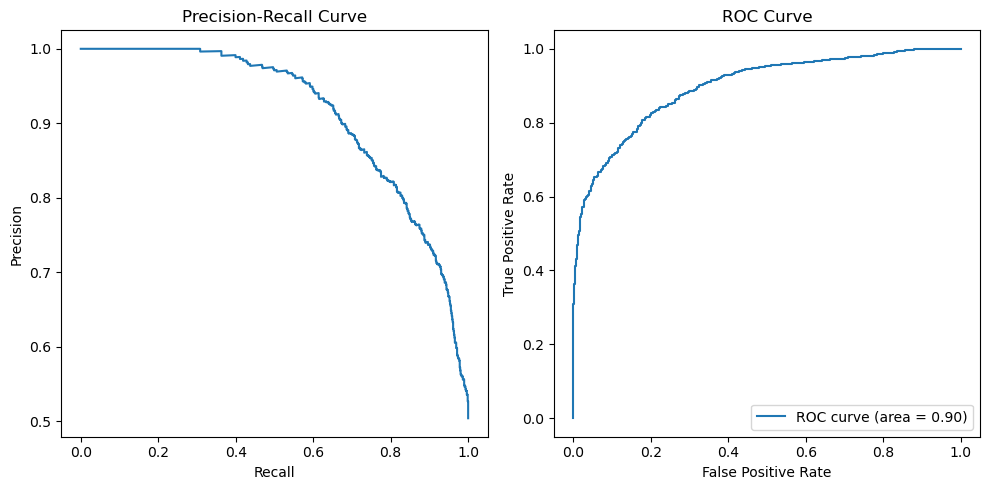

Optimal threshold: 0.494600385427475


In [24]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
import numpy as np

y_val_pred = tuner.get_best_models()[0].predict(X_val_preprocessed)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred)

# Calculate F1 scores for different thresholds
f1_scores = 2 * recall * precision / (recall + precision)

plt.figure(figsize=(10, 5))

# Plot Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")


In [25]:
# load the test data
df_test = pd.read_csv('data/test.csv')

# save PassengerId for submission
passenger_ids = df_test['PassengerId']

# process the test data like for the training
X_test, _ = process_data(df_test, isTrainSet=False)

# apply the pipeline to the test data
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# use the best model to predict the test data
y_test_pred = tuner.get_best_models()[0].predict(X_test_preprocessed)

# transform predictions into boolean values with optimal threshold
y_test_submit = (y_test_pred > optimal_threshold).astype(bool)

# create a dataframe with the passenger ids and predicted values
df_submit = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': y_test_submit.flatten()})
# save the dataframe as a csv file
df_submit.to_csv('data/submit_DNN_09.csv', index=False)
print(df_submit.head())


134/134 [==============================] - 0s 438us/step
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False
